# Deep Neural Network for Image Classification
We will use the functions that we have implemented in the last assigment to build a deep neural network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.

**dnn_app_utils.py** have all the functions which we have implemented in the previous assignment  

## Setup

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage
from dnn_app_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # set default size for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 1. Dataset
You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!.

**Problem Statement**: You are given a dataset containing ('train_catvsnoncat.h5', 'test_catvsnoncat.h5') containing:
+ a training set of m_train images labelled as cat (1) or non-cat (0)
+ a test set of m_test images labelled as cat and non-cat
+ each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images.

y = 1. It's a cat picture.


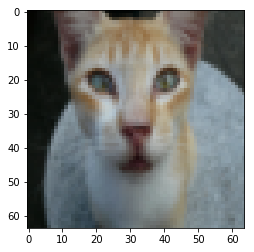

In [3]:
# Example of a picture
index = 11
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print(f"Number of training examples: {m_train}")
print(f"Number of testing examples: {m_test}")
print(f"Each image is of size: ({num_px}, {num_px}, {3})")
print(f"train_x_orig.shape: {train_x_orig.shape}")
print(f"train_y_orig.shape: {train_y.shape}")
print(f"test_x_orig.shape: {test_x_orig.shape}")
print(f"test_y.shape: {test_y.shape}")

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig.shape: (209, 64, 64, 3)
train_y_orig.shape: (1, 209)
test_x_orig.shape: (50, 64, 64, 3)
test_y.shape: (1, 50)


As usual reshape and standardize the images before feeding them into the network.

<img src='images/imvectorkiank.png' height=700 width=700/>

In [6]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  # '-1' makes the reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print(f"train_x shape: {train_x.shape}")
print(f"test_x shape: {test_x.shape}")

train_x shape: (12288, 209)
test_x shape: (12288, 50)


$12288 = 64 \times 64 \times 3$, which matches the size of one reshaped image vector

## 2. Architecture of our model
Now that we are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

We will build two different models:

+ A 2-layer neural network
+ An L-layer deep neural network

We will then compare the performance of these models, and also try out different values for $\mathcal{L}$.

Let's look at the two architectures.

### 2.1. 2-layer neural network

<img src='images/2layerNN_kiank.png' height=700 width=700/>

The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***.

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 2.2. L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 2.3. General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 3. Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [7]:
# constants defining the model
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [13]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a two layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    ----------
    X: input data, shape - (n_x, number of examples)
    Y: true "label" vector (containing 0 if non-cat and 1 if cat), of shape - (1, number of examples)
    layers_dims: dimension of layers (n_x, n_h, n_y)
    learning_rate: learning rate of gradient descent update rule 
    num_iterations: number of iterations of the optimization loop
    print_cost: if set to true print the value of the cost function after every 100 iterations
    
    Returns:
    --------
    parameters: a dict, containing W1, W2, b1, and b2 
    """
    np.random.seed(1)
    grads = {}
    costs = []         # to keep track of costs
    m = X.shape[1]     # no. of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters by calling one of the function previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # get initialized weights and biases
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    # Loop gradient descent
    for i in range(0, num_iterations):
        # Forward propagation: LINEAR->RELU->LINEAR->SIGMOID. Inputs, "X, W1, b1". Output: "A1, cache1, A2, cache2"
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Intialize backward propagation
        dA2 = -(np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs, "dA2, cache2, cache1". Outputs, "dA1, dW2, db2, dA0 (not used), dW1, db1" 
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dW1'] to 'dW1', grads['db1'] to 'db1', grads['dW2'] to 'dW2', grads['db2'] to 'db2' 
        grads['dW1'] = dW1
        grads['dW2'] = dW2
        grads['db1'] = db1
        grads['db2'] = db2
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters['W1']
        W2 = parameters['W2']
        b1 = parameters['b1']
        b2 = parameters['b2']
        
        # Print the cost afte every 100 iterations
        if print_cost and i%100 == 0:
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            costs.append(cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration (per tens)')
    plt.title(f"Learning rate = f{learning_rate}")
    plt.show()
    return parameters

Now train the model. If your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. 

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354664
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.40079775362038894
Cost after iteration 900: 0.35807050113237987
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213017
Cost after iteration 1300: 0.24681768210614857
Cost after iteration 1400: 0.19850735037466097
Cost after iteration 1500: 0.17448318112556624
Cost after iteration 1600: 0.17080762978096461
Cost after iteration 1700: 0.11306524562164715
Cost after iteration 1800: 0.0962942684593714
Cost after iteration 1900: 0.08342617959726857
Cost after iteration 2000: 0.07439078704319074
Cost after iteration 2100: 0.0663074

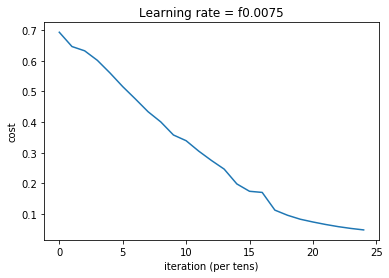

CPU times: user 5min 33s, sys: 37.9 s, total: 6min 11s
Wall time: 1min 2s


In [14]:
%%time
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), num_iterations=2500, print_cost=True)

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets.

In [17]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [18]:
predictions_test = predict(test_x, test_y, parameters) 

Accuracy: 0.72


**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and we will talk about it in the next course. Early stopping is a way to prevent overfitting.

Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an  𝐿 -layer model.

## 4. L-layer neural network